mamba install geopandas --override-channels -c conda-forge

mamba env update -f environment.yml --prune


In [9]:
# ---------- Imports ----------
from pathlib import Path
import json, math
import numpy as np
import rasterio
from rasterio.transform import from_origin
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import pandas as pd

import laspy
from pyproj import CRS
import subprocess
import sys

# PDAL (Python-Bindings)
import pdal

# ---------- Pfade ----------
# <--- passe diese drei Pfade an --->
pre_laz  = Path(r"D:\Dokumente\Time_series_analysis\project\norcia\data\merged_pre.laz")
post_laz = Path(r"D:\Dokumente\Time_series_analysis\project\norcia\data\merged_post.laz")
out_dir  = Path(r"D:\Dokumente\Time_series_analysis\project\norcia\outputs")
out_dir.mkdir(parents=True, exist_ok=True)

# Ausgabe-Dateien
pre_dsm_tif  = out_dir / "pre_DSM_25cm.tif"
post_dsm_tif = out_dir / "post_DSM_25cm.tif"
dod_tif      = out_dir / "DoD_pre_to_post.tif"      # post - pre
dod_masked   = out_dir / "DoD_masked_threshold.tif" # mit LoD-Schwelle


In [2]:
def laz_header_info(path: Path):
    with laspy.open(path) as f:
        h = f.header
        mins = h.mins
        maxs = h.maxs
        scale = h.scales
        offset = h.offsets
        return {
            "points": h.point_count,
            "mins": mins, "maxs": maxs,
            "scale": scale, "offset": offset,
            "crs": str(h.parse_crs()) if h.parse_crs() else None
        }

pre_info = laz_header_info(pre_laz)
post_info = laz_header_info(post_laz)
pre_info, post_info


({'points': 247756035,
  'mins': array([3.50601300e+05, 4.75232464e+06, 1.52792000e+03]),
  'maxs': array([3.51362050e+05, 4.75288979e+06, 1.82059000e+03]),
  'scale': array([0.01, 0.01, 0.01]),
  'offset': array([ 350000., 4752000.,      -0.]),
  'crs': 'EPSG:32633'},
 {'points': 162650169,
  'mins': array([3.50601310e+05, 4.75232922e+06, 1.52903000e+03]),
  'maxs': array([3.51359030e+05, 4.75288978e+06, 1.97664000e+03]),
  'scale': array([0.01, 0.01, 0.01]),
  'offset': array([0., 0., 0.]),
  'crs': 'PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["

In [3]:
# Overlap-Bounding-Box (Schnitt der Extents)
def intersect_bbox(a_mins, a_maxs, b_mins, b_maxs):
    xmin = max(a_mins[0], b_mins[0])
    ymin = max(a_mins[1], b_mins[1])
    xmax = min(a_maxs[0], b_maxs[0])
    ymax = min(a_maxs[1], b_maxs[1])
    if (xmax <= xmin) or (ymax <= ymin):
        raise ValueError("Keine räumliche Überlappung gefunden!")
    return (xmin, ymin, xmax, ymax)

overlap = intersect_bbox(pre_info["mins"], pre_info["maxs"], post_info["mins"], post_info["maxs"])
overlap


(np.float64(350601.31),
 np.float64(4752329.22),
 np.float64(351359.03),
 np.float64(4752889.78))

In [4]:
# Einheitliche Grid-Parameter
res = 0.25  # Meter Zellgröße
xmin, ymin, xmax, ymax = overlap

# PDAL writers.gdal verlangt eine "bounds" Klammer: ([minX, maxX], [minY, maxY])
bounds_str = f"([{xmin},{xmax}],[{ymin},{ymax}])"

def build_dsm_pipeline(in_laz: Path, out_tif: Path, bounds: str, res=0.25):
    pipe = {
        "pipeline": [
            { "type": "readers.las", "filename": str(in_laz) },
            { "type": "filters.crop", "bounds": bounds },
            {
                "type": "writers.gdal",
                "filename": str(out_tif),
                "resolution": res,
                "radius": res,
                "gdaldriver": "GTiff",
                "output_type": "max",
                "dimension": "Z",
                "nodata": -9999.0,
                "data_type": "float32",
                "bounds": bounds,
            }
        ]
    }
    return pdal.Pipeline(json.dumps(pipe))



# DSMs erstellen
for laz, tif in [(pre_laz, pre_dsm_tif), (post_laz, post_dsm_tif)]:
    if not tif.exists():
        p = build_dsm_pipeline(laz, tif, bounds_str, res=res)
        n = p.execute()
        print(f"Wrote {tif} with {n} pdal stages.")
    else:
        print(f"Exists: {tif}")


Wrote D:\Dokumente\Time_series_analysis\project\norcia\outputs\pre_DSM_25cm.tif with 247756026 pdal stages.
Wrote D:\Dokumente\Time_series_analysis\project\norcia\outputs\post_DSM_25cm.tif with 162650169 pdal stages.


In [5]:
def read_raster(path):
    ds = rasterio.open(path)
    arr = ds.read(1, masked=True)
    profile = ds.profile
    return ds, arr, profile

_, pre_arr, pre_prof = read_raster(pre_dsm_tif)
_, post_arr, post_prof = read_raster(post_dsm_tif)

assert pre_prof["transform"] == post_prof["transform"], "Raster-Grid unterscheidet sich!"
assert pre_prof["width"] == post_prof["width"] and pre_prof["height"] == post_prof["height"]

# DoD: post - pre
dod = post_arr - pre_arr

# LoD (einfach): 3 cm
lod = 0.03
dod_mask = np.ma.masked_where(np.abs(dod) < lod, dod)

# Schreiben
def write_raster(path, arr, profile):
    prof = profile.copy()
    prof.update(dtype=rasterio.float32, nodata=-9999.0, compress="LZW")
    with rasterio.open(path, "w", **prof) as dst:
        data = arr.filled(-9999.0).astype("float32")
        dst.write(data, 1)

write_raster(dod_tif, dod, pre_prof)
write_raster(dod_masked, dod_mask, pre_prof)

print("DoD geschrieben:", dod_tif)
print("DoD (maskiert) geschrieben:", dod_masked)


DoD geschrieben: D:\Dokumente\Time_series_analysis\project\norcia\outputs\DoD_pre_to_post.tif
DoD (maskiert) geschrieben: D:\Dokumente\Time_series_analysis\project\norcia\outputs\DoD_masked_threshold.tif


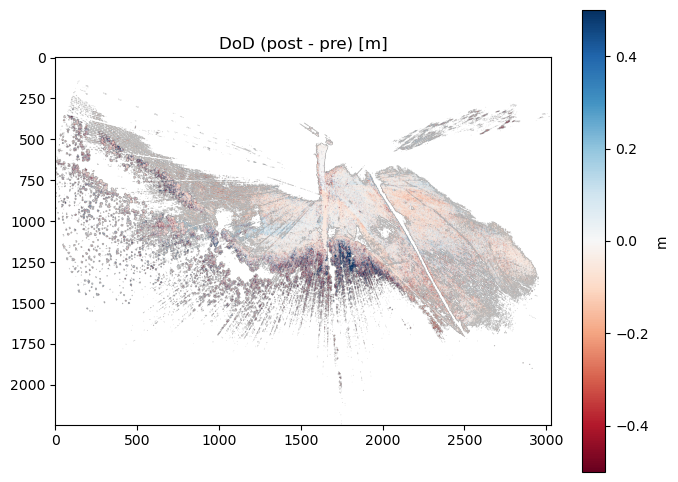

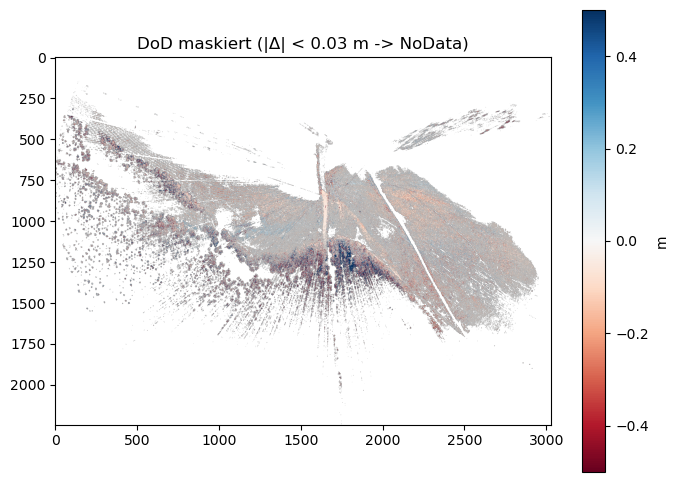

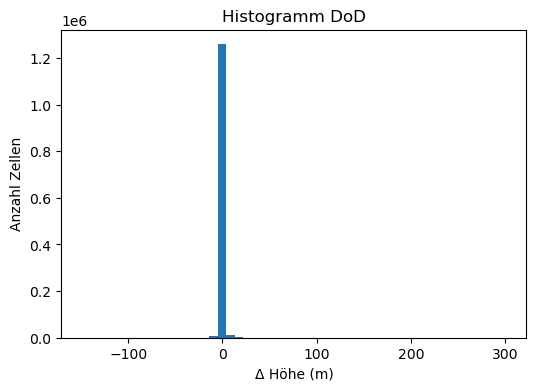

In [6]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(dod, cmap="RdBu", vmin=-0.5, vmax=0.5)  # Stretch anpassen
ax.set_title("DoD (post - pre) [m]")
fig.colorbar(im, ax=ax, label="m")
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(dod_mask, cmap="RdBu", vmin=-0.5, vmax=0.5)
ax.set_title(f"DoD maskiert (|Δ| < {lod} m -> NoData)")
fig.colorbar(im, ax=ax, label="m")
plt.show()

# Histogramm
vals = dod.compressed()
plt.figure(figsize=(6,4))
plt.hist(vals, bins=50)
plt.title("Histogramm DoD")
plt.xlabel("Δ Höhe (m)")
plt.ylabel("Anzahl Zellen")
plt.show()


In [ ]:
import py4dgeo as p4d
import numpy as np
from pathlib import Path

# --- Epochs direkt aus LAZ-Dateien laden ---
# Vorteil: keine riesigen numpy-Arrays im RAM
epoch_pre = p4d.read_from_las(pre_laz)
epoch_post = p4d.read_from_las(post_laz)

# --- Subsampling für Corepoints ---
# Hier wählst du jeden 100. Punkt als Corepoint
corepoints = epoch_pre.cloud[::100]

# --- Optional: Registrierung/Stable Parts prüfen ---
# reg_error = np.nanstd(m3c2_distances_stableparts)  # falls du Stable-Parts vorher berechnest
reg_error = 0.0  # Setze 0, falls nicht bekannt

# --- M3C2 parametrisieren ---
m3c2 = p4d.M3C2(
    epochs=(epoch_pre, epoch_post),
    corepoints=corepoints,
    normal_radii=(0.5, 1.0, 2.0),   # mehrere Skalen für Normalenschätzung
    cyl_radii=(0.5,),                # Radius für Projektion entlang Normalen
    max_distance=(5.0,),             # maximale Suche entlang Normal
    registration_error=(reg_error,)
)

# --- M3C2 ausführen ---
distances, uncertainties = m3c2.run()

# --- Statistik ---
print(f"Median M3C2 distance: {np.nanmedian(distances):.3f} m")
print(f"Std. dev. M3C2 distances: {np.nanstd(distances):.3f} m")

# --- Ergebnisse speichern ---
output_las = out_dir / "m3c2_results.las"
attributes_to_save = {
    "distance": distances,
    "lodetection": uncertainties["lodetection"],
    "spread1": uncertainties["spread1"],
    "spread2": uncertainties["spread2"],
    "num_points1": uncertainties["num_samples1"],
    "num_points2": uncertainties["num_samples2"],
}

p4d.write_m3c2_results_to_las(str(output_las), m3c2, attributes_to_save)
print("Ergebnisse gespeichert unter:", output_las)

# --- Speicher freigeben ---
epoch_pre = None
epoch_post = None
corepoints = None


[2025-08-20 13:06:08][INFO] Reading point cloud from file 'D:\Dokumente\Time_series_analysis\project\norcia\data\merged_pre.laz'
[2025-08-20 13:07:18][INFO] Reading point cloud from file 'D:\Dokumente\Time_series_analysis\project\norcia\data\merged_post.laz'


[2025-08-20 13:08:16][WARNING] DEPRECATION: use cyl_radius instead of cyl_radii. In a future version, cyl_radii will be removed!


[2025-08-20 13:08:16][INFO] Building KDTree structure with leaf parameter 10
[2025-08-20 13:10:44][INFO] Building KDTree structure with leaf parameter 10


In [ ]:
def dsm_to_grid_mesh_obj(dsm_path: Path, out_obj: Path, max_tri_side=1.0):
    """Erzeugt ein regelmäßiges Dreiecksmesh aus einem DSM-GeoTIFF.
       Achtung: Für große Raster kann das sehr groß werden – ggf. clippen!"""
    with rasterio.open(dsm_path) as ds:
        Z = ds.read(1, masked=True)
        transform = ds.transform
        resx = transform.a
        resy = -transform.e
        # Downsample, falls sehr fein
        scale = max(1, int(math.ceil(max(resx, resy) / (max_tri_side/2))))
        if scale > 1:
            Z = Z[::scale, ::scale]
            transform = rasterio.Affine(transform.a*scale, 0, transform.c,
                                        0, transform.e*scale, transform.f)

        nrows, ncols = Z.shape
        xs = transform.c + np.arange(ncols)*transform.a
        ys = transform.f + np.arange(nrows)*transform.e

        # Grid -> Punkte
        XX, YY = np.meshgrid(xs, ys)
        mask = ~Z.mask if np.ma.isMaskedArray(Z) else np.ones_like(Z, dtype=bool)
        # Open3D Mesh aus Dreiecksvermaschung
        # Wir triangulieren regulär (i,j)-(i+1,j)-(i,j+1) und (i+1,j)-(i+1,j+1)-(i,j+1) wo alle Z gültig sind
        verts = []
        for i in range(nrows):
            for j in range(ncols):
                if mask[i, j]:
                    verts.append([XX[i, j], YY[i, j], float(Z[i, j])])
                else:
                    verts.append([XX[i, j], YY[i, j], np.nan])
        verts = np.array(verts, dtype=float)

        # Indizes
        def idx(i, j): return i*ncols + j
        triangles = []
        for i in range(nrows-1):
            for j in range(ncols-1):
                idxs = [idx(i,j), idx(i+1,j), idx(i,j+1), idx(i+1,j+1)]
                if all(not np.isnan(verts[k,2]) for k in [idxs[0], idxs[1], idxs[2]]):
                    triangles.append([idxs[0], idxs[1], idxs[2]])
                if all(not np.isnan(verts[k,2]) for k in [idxs[1], idxs[3], idxs[2]]):
                    triangles.append([idxs[1], idxs[3], idxs[2]])

        mesh = o3d.geometry.TriangleMesh()
        mesh.vertices = o3d.utility.Vector3dVector(verts)
        mesh.triangles = o3d.utility.Vector3iVector(np.array(triangles, dtype=np.int32))
        mesh.remove_unreferenced_vertices()
        mesh.remove_degenerate_triangles()
        mesh.remove_duplicated_triangles()
        mesh.remove_duplicated_vertices()
        mesh.compute_vertex_normals()

        o3d.io.write_triangle_mesh(str(out_obj), mesh, write_triangle_uvs=False)
        return out_obj

post_mesh_obj = out_dir / "post_DSM_mesh.obj"
if not post_mesh_obj.exists():
    dsm_to_grid_mesh_obj(post_dsm_tif, post_mesh_obj, max_tri_side=1.0)
    print("Mesh geschrieben:", post_mesh_obj)
else:
    print("Mesh existiert:", post_mesh_obj)


In [ ]:
# Grobe Szene-Ausdehnung (aus overlap)
scene_bbox = {"xmin": xmin, "xmax": xmax, "ymin": ymin, "ymax": ymax}
center_x = (xmin + xmax)/2
center_y = (ymin + ymax)/2

helios_dir = out_dir / "helios"
helios_dir.mkdir(exist_ok=True)
scene_json = helios_dir / "scene_stitched.json"
uav_sensor_json = helios_dir / "sensor_uav.json"
als_sensor_json = helios_dir / "sensor_als.json"

# Szene mit Mesh
scene_cfg = {
  "scene": {
    "id": "norcia_scene",
    "meshes": [
      {"id": "surface", "path": str(post_mesh_obj), "scale": 1.0}
    ]
  }
}

# Einfache Linienflugbahn über der Szene:
def make_line_trajectory(xmin, xmax, y, z, duration=30.0, steps=5):
    # steps Wegpunkte linear verteilt
    xs = np.linspace(xmin, xmax, steps)
    t0 = 0.0
    dt = duration/(steps-1)
    traj = []
    for i,x in enumerate(xs):
        traj.append({"x": float(x), "y": float(y), "z": float(z), "time": round(t0 + i*dt,3)})
    return traj

# UAV (ULS) – niedrige Flughöhe, relativ schmale FOV
uav_alt_agl = 120.0  # m
uav_y = center_y
uav_traj = make_line_trajectory(xmin+50, xmax-50, uav_y, z=uav_alt_agl, duration=40, steps=7)

uav_cfg = {
  "sensor": {
    "id": "uav_lidar",
    "type": "rotating",
    "fov": 60.0,                # Grad
    "frequency": 200000,        # Pulsrate (Hz) – exemplarisch
    "scanlines": 16,            # Kanäle
    "angularResolution": 0.2,   # Grad
    "trajectory": uav_traj
  }
}

# ALS – höhere Flughöhe, breiteres FOV
als_alt_agl = 800.0
als_y = center_y + 100.0
als_traj = make_line_trajectory(xmin+100, xmax-100, als_y, z=als_alt_agl, duration=40, steps=5)

als_cfg = {
  "sensor": {
    "id": "als_lidar",
    "type": "rotating",
    "fov": 80.0,
    "frequency": 300000,        # typ. höhere PRF
    "scanlines": 32,
    "angularResolution": 0.25,
    "trajectory": als_traj
  }
}

# Schreiben
scene_json.write_text(json.dumps(scene_cfg, indent=2))
uav_sensor_json.write_text(json.dumps(uav_cfg, indent=2))
als_sensor_json.write_text(json.dumps(als_cfg, indent=2))

print("HELIOS++ Dateien geschrieben:")
print(scene_json)
print(uav_sensor_json)
print(als_sensor_json)


In [ ]:
# Beispiel-Kommandos (nur ausführen, wenn helios++ in PATH):
helios_bin = "helios++"  # ggf. absoluter Pfad, z. B. r"C:\tools\helios\helios++.exe"

uav_out = helios_dir / "uav_output"
als_out = helios_dir / "als_output"
uav_out.mkdir(exist_ok=True); als_out.mkdir(exist_ok=True)

def run_helios(scene, sensor, outfolder):
    cmd = [helios_bin, "simulate", "-s", str(scene), "-c", str(sensor), "-o", str(outfolder)]
    print("RUN:", " ".join(cmd))
    try:
        subprocess.run(cmd, check=True)
    except FileNotFoundError:
        print("⚠️ HELIOS++ nicht gefunden. Bitte Pfad in 'helios_bin' setzen.")

# run_helios(scene_json, uav_sensor_json, uav_out)
# run_helios(scene_json, als_sensor_json, als_out)


In [ ]:
# Beispiel: UAV-DSM erzeugen (wie oben mit PDAL) -> uav_dsm_tif
# Dann Differenz zur TLS-Referenz (z. B. post_DSM_25cm) bilden

uav_dsm_tif = helios_dir / "uav_DSM_25cm.tif"  # <- vorher wie in Schritt 3 rasterisieren
als_dsm_tif = helios_dir / "als_DSM_25cm.tif"

# Pseudocode (so wie oben bei DoD):
# _, uav_arr, _ = read_raster(uav_dsm_tif)
# diff_uav_tls = uav_arr - post_arr  # oder pre_arr
# -> RMSE, MAE, %Abdeckung, Histogramm, Heatmap
